In [1]:
import os

import torch

from PIL import Image
import moviepy.editor as mpy
from IPython.core.display import display, HTML

from torch.nn import functional as F
from torch.autograd import Variable
from math import ceil
from models import TSN
import torchvision
from transforms import *
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import euclidean_distances
import torch.nn.functional as F


def load_model(useGPU=True):
    model = TSN(64,
              8,
              'RGB',
              base_model='InceptionV3',
              consensus_type='TRNmultiscale',
              img_feature_dim=256, print_spec=False)
    
    weight_file = '/home/ec2-user/gif-recommendations/model_train/trn_moments_model/trn_pytorch/model/TRN_custom_RGB_InceptionV3_TRNmultiscale_segment8_best.pth.tar'
    
    if useGPU:
        model = model.cuda()
        checkpoint = torch.load(weight_file)
    else:
        checkpoint = torch.load(weight_file, map_location=lambda storage,
                                loc: storage)  # allow cpu

    base_dict = {'.'.join(k.split('.')[1:]): v for k, v in list(checkpoint['state_dict'].items())}
    model.load_state_dict(base_dict)
    model.eval()
    model.train(False)
    
    for p in model.parameters():
        p.requires_grad = False
    
    return model


def load_transform():
    """Load the image transformer."""
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda frames: [Image.fromarray(x) for x in frames]),
        GroupOverSample(model.input_size, model.scale_size),
        Stack(roll=True),
        ToTorchFormatTensor(div=False),
        GroupNormalize(model.input_mean, model.input_std),
    ])
    return transform

def evenly_spaced_sampling(array, n):
    """Choose `n` evenly spaced elements from `array` sequence"""
    length = len(array)

    if n == 0 or length == 0:
        return []
    elif n == length:
        return array
    elif n < length:
        return [array[ceil(i * length / n)] for i in range(n)]
    elif n > length:
        result = []
        for _ in range(ceil(n / length)):
            result.extend(array)
        return result[:n]


model = load_model(useGPU=True)

# Load the video frame transform
transform = load_transform()

def process_gif(gif_id, model=model, transform=transform, samples_num=8):
    gif = mpy.VideoFileClip(f'https://media.giphy.com/media/{gif_id}/giphy.mp4')
    frames = evenly_spaced_sampling(list(gif.iter_frames()), samples_num)
    del gif
    
    data = transform(frames)
    with torch.no_grad():
        input_var = torch.autograd.Variable(data.view(-1, 3, data.size(1), data.size(2))).unsqueeze(0).cuda()
    
        # Make video prediction
        logits = model(input_var)
        return logits.cpu().data.mean(dim=0, keepdim=True)
    
def display_gifs(gif_ids, width=150, height_pct=100):
    display(HTML(f"""
        <div style='display: flex; flex-wrap: wrap;'>
            {''.join(f"<a href={get_gif_url(x)} style='width: {width}px; height: {height_pct}%; margin: 5px'><img src={get_gif_url(x)} alt={x} /></a>" for x in gif_ids)}
        </div>
    """))
    
def get_gif_url(id, ext='gif'):
    return f'https://media.giphy.com/media/{id}/giphy.{ext}'

Multi-Scale Temporal Relation Network Module in use ['8-frame relation', '7-frame relation', '6-frame relation', '5-frame relation', '4-frame relation', '3-frame relation', '2-frame relation']
Freezing BatchNorm2D except the first one.
Freezing BatchNorm2D except the first one.


In [2]:
def distance(v1, v2):
    return F.pairwise_distance(v1, v2).squeeze(0)[0]

def analyze_pair(gif1, gif2):
    display_gifs([gif1, gif2])
    embedding1 = process_gif(gif1)
    embedding2 = process_gif(gif2)
    return distance(embedding1, embedding2)

In [8]:
import pickle

dataset = pickle.load(open('/home/ec2-user/siamese_dataset.pkl', 'rb'))

In [9]:
dataset[:10]

[{'26ooAPkP9FPqk6e9s1', '65R4yT6qwFcBI6WAn4'},
 {'4ryp9Ihw0BEyc', 'XOY5y7YXjTD7q'},
 {'3oEduUQtEx8YEdQ2w8', 'jTHJsHfVypYl3iLBHC'},
 {'3oKGzayyPJGE7xuytO', 'l4FszqrMzZpWs1ZMQ'},
 {'8ifa9TRWaiqNG', 'YlEMMJMwAeaPK', 'jrU2YGXXZOiJO'},
 {'DhyveKEG12Vi0', 'XfrQAetZuPeN2'},
 {'Tu96GNA7BH5T2', 'dAS5aQ5mbA6o8'},
 {'CjNifqd0JIgV6biOjK', 'XumwweOEq89ZS'},
 {'3o6vY4wVYwGuosjJHW', 'xT39D66wnoy8uUvkkg'},
 {'NSGAQbgnFbph5wybNX', 'l1VUuoQB6wkX4cQSW5'}]

In [9]:
embeddings = []

for i, gifs in enumerate(dataset):
    embeddings.append([process_gif(x) for x in gifs])

In [21]:
distances = []
for x in embeddings:
    matrix = cosine_distances(x, x)
    i, j = np.triu_indices(matrix.shape[0], 1)
    top_triangle = matrix[i, j]
    distances.append(top_triangle)

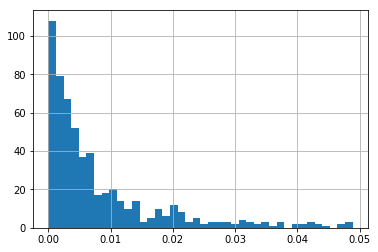

In [22]:
import pandas as pd
pd.Series([x * 10000 for matr in distances for x in matr if x * 10000 < 0.05]).hist(bins=40)

In [23]:
import random

distances = []
for x in range(500):
    a, b = random.sample(embeddings, 2)
    vector1, vector2 = random.choice(a), random.choice(b)
    dist = distance(vector1, vector2)
    distances.append(dist)

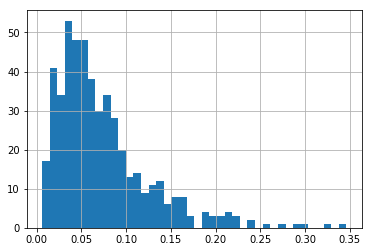

In [25]:
pd.Series([x * 10000 for x in distances]).hist(bins=40)

In [14]:
for x in dataset[:10]:
    a = analyze_pair(*list(x)[:2])
    print(a)

tensor(0.0719)


tensor(0.1312)


tensor(0.0918)


tensor(0.1412)


tensor(0.2095)


tensor(0.0434)


tensor(0.1969)


tensor(0.0633)


tensor(0.1348)


tensor(0.4972)


In [15]:
for x in range(10):
    a, b = random.sample(dataset, 2)
    gif1, gif2 = random.choice(list(a)), random.choice(list(b))
    a = analyze_pair(gif1, gif2)
    print(a)

tensor(1.5497)


tensor(0.8045)


tensor(1.1329)


tensor(0.4412)


tensor(1.3802)


tensor(1.9684)


tensor(0.4568)


tensor(1.9606)


tensor(1.1573)


tensor(0.8957)


In [7]:
analyze_pair('26AHOLVWrGbM4zMys', 'l1J9ICtOvOG9XSaXK')

tensor(1.1674)

In [6]:
analyze_pair('26ooAPkP9FPqk6e9s1', 'l1J9ICtOvOG9XSaXK')

tensor(0.6305)

In [5]:
analyze_pair('l1J9ICtOvOG9XSaXK', '65R4yT6qwFcBI6WAn4')

tensor(0.6030)

In [3]:
process_gif('YlEMMJMwAeaPK')

tensor([[ 0.9312,  0.3801,  0.3544, -0.3473, -1.1882, -0.0616, -0.6151, -1.4151,
         -0.3929,  0.3521, -1.0951, -2.0828,  1.0252,  0.6996,  1.0604, -0.5678,
         -1.6645, -0.6920,  1.5157,  0.3836,  0.2021, -0.5234, -1.3466, -1.5230,
         -0.7865,  1.2755, -1.0113, -1.6809, -1.3282, -1.8277,  0.9909,  0.3874,
          0.4252,  0.2709,  0.6332,  0.2527,  0.7623,  1.0579,  1.6045,  0.1014,
         -1.1900, -0.2541,  0.2254,  1.8101,  0.8842, -0.6546,  0.9181,  1.1814,
         -0.7803, -0.8435,  0.2437,  1.8758, -0.7070, -1.9417, -1.8387,  0.8717,
          0.7864, -0.9625, -1.1503,  0.6043,  0.2885,  0.2647, -0.9535,  0.6792]])

In [4]:
process_gif('26AHOLVWrGbM4zMys')

tensor([[ 1.2042,  0.3718,  0.3372, -0.9457, -1.4839, -0.2239, -0.5049, -1.2134,
         -0.4582,  0.4498, -0.5878, -2.1600,  0.9390,  0.6204,  0.9725, -0.3926,
         -1.4749, -0.5241,  1.6081,  0.6160,  0.4941, -0.7329, -1.3451, -1.3487,
         -0.9270,  1.1555, -1.7773, -1.6084, -0.7934, -1.6868,  0.7975,  0.2587,
          0.4989, -0.3777,  0.8173,  0.2505,  0.7500,  0.7297,  1.6664,  0.5043,
         -1.1479, -0.0438,  0.0762,  1.5756,  1.2059, -0.7853,  0.8546,  0.9535,
         -0.1056, -1.1277,  0.3740,  1.2736, -0.3730, -1.6024, -1.6916,  0.9611,
          0.7835, -0.7510, -1.1798,  0.1317, -0.2312,  0.2431, -1.5007,  0.8385]])